# Description
Investigate randomness of movement of infected cells based on trackmate results.

In Infectio, the direction of movement of infected cells in opposite direction
of VGF gradient is changed by rotating the direction with an angle samples from
a normal distribution, to model the randomness.

Here, this angle is investigated, to obtain good estimates for the normal
distribution model. Since we do not know the VGF gradient direction (deterministic
factor of the direction), the average over a window is considered. Here, the 1 frame
direction is compared versus some average movement direction e.g. window size 5 and 10.


In [2]:
import pandas as pd
import numpy as np

def angles_backwarddif_vs_windowedcentraldif(csv_files, half_window=3):
    """angle between the frame direction (direction from previous frame to current frame) 
    and a longer horizon direction defined by the two window parameters extracted
    from the list of trackamte csv files."""
    # Read the csv data in csv_files and only keep a selection of columns. Also add
    # the number of in the file name to the TRACK_ID column with - in between
    dfs = []
    keep_cols = ["POSITION_X", "POSITION_Y", "FRAME", "TRACK_ID"]
    for f in csv_files:
        df = pd.read_csv(f, skiprows=[1, 2, 3], low_memory=False)
        df["TRACK_ID"] = f.split("/")[-1].split("-")[0] + '_' + df['TRACK_ID'].astype(str)
        df = df[keep_cols]
        dfs.append(df)

    df = pd.concat(dfs, ignore_index=True)

    # Add column to it called INF_TIME that for each track id finds the one with the
    # lowest frame number and substracts this from the frame number for all entries
    # with the same TRACK_ID
    df["INF_TIME"] = df["FRAME"] - df.groupby("TRACK_ID")["FRAME"].transform(min)

    # Create new column called FORWARD_DIF_X that subtracks the value of POSITION_X
    # with the value for the entry with same TRACK_ID but INF_TIME-1 (if INF_TIME is
    # 0 then just put 0 in it)
    df.sort_values(by=["TRACK_ID", "INF_TIME"], inplace=True)
    df["BACKWARD_DIF_X"] = df.groupby("TRACK_ID")["POSITION_X"].diff().fillna(0)  # diff does the forward difference
    df["BACKWARD_DIF_Y"] = df.groupby("TRACK_ID")["POSITION_Y"].diff().fillna(0)

    grouped = df.groupby("TRACK_ID")
    df["CENTRAL_DIF_X"] = np.nan
    df["CENTRAL_DIF_Y"] = np.nan

    HALF_WINDOW = half_window

    for _, group in grouped:
        sorted_group = group.sort_values(by="INF_TIME")
        value_x = (
            sorted_group["POSITION_X"].values[2 * HALF_WINDOW + 1:] -
            sorted_group["POSITION_X"].values[:-2 * HALF_WINDOW - 1]
        )
        value_y = (
            sorted_group["POSITION_Y"].values[2 * HALF_WINDOW + 1:] -
            sorted_group["POSITION_Y"].values[:-2 * HALF_WINDOW - 1]
        )
        df.loc[sorted_group.index[HALF_WINDOW + 1:-HALF_WINDOW], "CENTRAL_DIF_X"] = value_x
        df.loc[sorted_group.index[HALF_WINDOW + 1:-HALF_WINDOW], "CENTRAL_DIF_Y"] = value_y
    
    angles = np.arctan2(df['CENTRAL_DIF_Y'] * df['BACKWARD_DIF_X'] - df['CENTRAL_DIF_X'] * df['BACKWARD_DIF_Y'],
                    df['CENTRAL_DIF_X'] * df['BACKWARD_DIF_X'] + df['CENTRAL_DIF_Y'] * df['BACKWARD_DIF_Y'])
    return angles

In [7]:
import os

CSV_ROOT = "../dataset/plaques-ashkan/trackmate_output/dVGF_dF11_viruses/M061"
csv_files_wr = [os.path.join(CSV_ROOT, f) for f in os.listdir(CSV_ROOT) if f.endswith(".csv") and int(f.split("-")[0]) in range(1, 16)]
print(csv_files_wr)
angles_wr_1 = angles_backwarddif_vs_windowedcentraldif(csv_files_wr, half_window=1)
angles_wr_3 = angles_backwarddif_vs_windowedcentraldif(csv_files_wr, half_window=3)
angles_wr_5 = angles_backwarddif_vs_windowedcentraldif(csv_files_wr, half_window=5)

['../dataset/plaques-ashkan/trackmate_output/dVGF_dF11_viruses/M061/5-spots.csv', '../dataset/plaques-ashkan/trackmate_output/dVGF_dF11_viruses/M061/8-spots.csv', '../dataset/plaques-ashkan/trackmate_output/dVGF_dF11_viruses/M061/3-spots.csv', '../dataset/plaques-ashkan/trackmate_output/dVGF_dF11_viruses/M061/11-spots.csv', '../dataset/plaques-ashkan/trackmate_output/dVGF_dF11_viruses/M061/4-spots.csv', '../dataset/plaques-ashkan/trackmate_output/dVGF_dF11_viruses/M061/9-spots.csv', '../dataset/plaques-ashkan/trackmate_output/dVGF_dF11_viruses/M061/2-spots.csv', '../dataset/plaques-ashkan/trackmate_output/dVGF_dF11_viruses/M061/10-spots.csv', '../dataset/plaques-ashkan/trackmate_output/dVGF_dF11_viruses/M061/7-spots.csv', '../dataset/plaques-ashkan/trackmate_output/dVGF_dF11_viruses/M061/15-spots.csv', '../dataset/plaques-ashkan/trackmate_output/dVGF_dF11_viruses/M061/1-spots.csv', '../dataset/plaques-ashkan/trackmate_output/dVGF_dF11_viruses/M061/13-spots.csv', '../dataset/plaques-ash

62.050999698742686
66.55804121066753
69.22544047080402


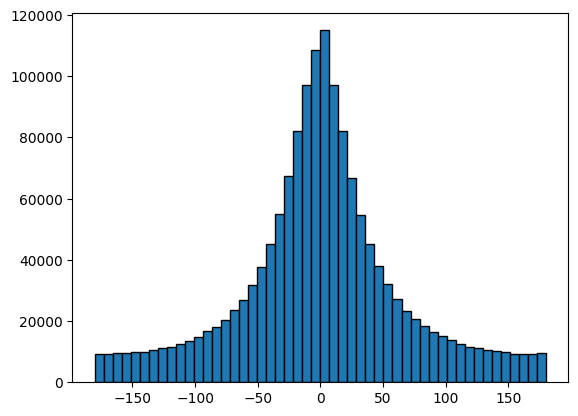

In [8]:
from matplotlib import pyplot as plt

plt.hist(np.degrees(angles_wr_3), bins=50, edgecolor='black');
print(np.degrees(angles_wr_1).std())
print(np.degrees(angles_wr_3).std())
print(np.degrees(angles_wr_5).std())

# Conclusion
Not as I'd hoped. std too large and not so much noise.